In [1]:
import random
import os
from urllib import request
import sklearn

# Resources

In order to run this notebook, you first need the following: 

## The _Don't Patronize Me!_ dataset

Files contained in the _Don't Patronize Me!_ data file, which you can access from [here](https://github.com/Perez-AlmendrosC/dontpatronizeme) (you need to fill a short form and it will be sent to you).

## The `dont_patronize_me.py` module

You can get this file by running the cell below.

In [2]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


## The official scorer

The script `evaluation.py` can also be obtained by running the cell below:

In [3]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


At this point, your left pane on Google Colab should look like this:

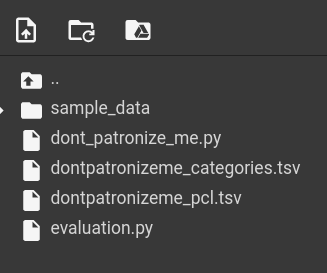

In [4]:
from dont_patronize_me import DontPatronizeMe
# Initialize a dpm (Don't Patronize Me) object.
# It takes two areguments as input: 
# (1) Path to the directory containing the training set files, which is the root directory of this notebook.
# (2) Path to the test set, which will be released when the evaluation phase begins. In this example, 
# we use the dataset for Subtask 1, which the code will load without labels.
dpm = DontPatronizeMe('data', 'dontpatronizeme_pcl.tsv')

# Load Subtask 1 data

Note that the original dataset contains fine-grained tags (0 to 4, both inclusive). The interface we provide collapses them into binary labels, which is the labeling we use for the task.

In [5]:
# This method loads the subtask 1 data
dpm.load_task1()
# which we can then access as a dataframe
dpm.train_task1_df.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"we 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"in libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""white house press secretary sean spicer said ...",0,0
3,4,@@7811231,disabled,nz,council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" just like we received migrants fleeing el ...",0,0


# Load Subtask 2 data

Similarly, you can use our data manager code to have a binary vector representing the labels of each paragraph in the multilabel classification subtask (PCL categories, Subtask 2).

In [6]:
# Same for subtask 2
dpm.load_task2()
# which we can then access as a dataframe
dpm.train_task2_df.head()

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


,par_id,art_id,text,keyword,country,label
0,4046,@@14767805,we also know that they can benefit by receivin...,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,@@7896098,pope francis washed and kissed the feet of mus...,refugee,ng,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,@@17252299,many refugees do n't want to be resettled anyw...,refugee,ng,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,@@3002894,"""budding chefs , like """" fred """" , """" winston ...",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,@@25597822,"""in a 90-degree view of his constituency , one...",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]"


In [7]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# Generate predictions

In this example, our code will just generate a bunch of random predictions for both subtasks.

In [8]:
# first, we need to create the res/ and ref/ folders, which the evaluator expects
!mkdir ref res

mkdir: cannot create directory ‘ref’: File exists
mkdir: cannot create directory ‘res’: File exists


In [9]:
dpm.load_test()

In [10]:
# random predictions for task 1
preds_task1 = [[random.randint(0,1)] for k in range(0,len(dpm.test_set))]
labels2file(preds_task1, os.path.join('res/', 'task1.txt'))

In [11]:
# random predictions for task 2
preds_task2 = [[random.choice([0,1]) for k in range(7)] for k in range(0,len(dpm.test_set))]
labels2file(preds_task2, os.path.join('res/', 'task2.txt'))

# Evaluate predictions

After generating two prediction files (`task1.txt` and `task2.txt`), we can just call the scorer (`evaluation.py`), which will generate a `scores.txt` file.

## Get gold labels

We will use the gold labels of the training set and compare our random predictions to them.

In [12]:
# for subtask 1 (we convert our list of labels into a list of lists to make 
# it compatible with the labels2file function)
labels2file(dpm.train_task1_df.label.apply(lambda x:[x]).tolist(), os.path.join('ref/', 'task1.txt'))
# and for subtask 2
labels2file(dpm.train_task2_df.label.tolist(), os.path.join('ref/', 'task2.txt'))

## Call task scorer and print results

In [13]:
# Now, we can just call the official scorer, which takes an input_directory and an output_directory
# as arguments. In this example, both will be the root directory of this notebook.
!python evaluation.py . .

In [14]:
# The scorer generated a results file called "scores.txt". 
# We can now see the performance of a random baseline on the training set.
!cat scores.txt

task1_precision:0.08872209391839876
task1_recall:0.46424974823766363
task1_f1:0.14897398610437873
task2_unb:0.5775577557755776
task2_sha:0.29957203994293863
task2_pre:0.31843575418994413
task2_aut:0.33798882681564246
task2_met:0.27299703264094954
task2_com:0.4620187304890739
task2_the:0.06766917293233084
task2_avg:0.3337484732552081


# Project Work (Kai and Mustafa)



## Preprocessing for standard ML model building for task 1

In [20]:
# This cell is boilerplate copied from the HW3 word_embedding.ipynb
import gensim.downloader as api

def download_word2vec_embeddings():
    print("Beginning pre-trained word embedding download")
    wv = api.load("word2vec-google-news-300")
    print(f"\nLoading completed\nVocab size: {len(wv.vocab)}")
    return wv

word2vec = download_word2vec_embeddings()

Beginning pre-trained word embedding download
[==------------------------------------------------] 5.5% 91.3/1662.8MB downloaded

KeyboardInterrupt: ignored

In [ ]:
!pip install nltk
import nltk
from preprocess import clean_text
nltk.download('punkt')
dpm.train_task1_df["tokenized"] = dpm.train_task1_df["text"].apply(lambda x: nltk.word_tokenize(clean_text(x)))

In [ ]:
import numpy as np
# Generate paragraph embeddings for a given text by averaging (which is what I assume they did)
def paragraph_embedding(sentence: list) -> np.ndarray:
    words = [word for word in sentence if word in word2vec.vocab]
    return np.mean(word2vec[words], axis=0)

In [ ]:
from sklearn import model_selection
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(dpm.train_task1_df["tokenized"],dpm.train_task1_df["label"],test_size=0.2)

In [ ]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
train_Y = Encoder.fit_transform(train_Y)
test_Y = Encoder.fit_transform(test_Y)

In [ ]:
# Turn the train_X into a 2d sample x feature vector using paragraph_embedding
train_X_para_embed = np.array([paragraph_embedding(text) for text in train_X])
test_X_para_embed = np.array([paragraph_embedding(text) for text in test_X])
train_X_para_embed.shape

## SVM-WV

In [ ]:
from sklearn.svm import SVC

#Model based on hyperperameters found here https://aclanthology.org/2020.coling-main.518.pdf
SVM = SVC(C=100, kernel="poly", gamma="scale")
SVM.fit(train_X_para_embed,train_Y)
predictions_SVM = SVM.predict(test_X_para_embed)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions_SVM, test_Y))

## SVM-BoW

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_X_bow = vectorizer.fit_transform(dpm.train_task1_df['text'])
train_X_bow

In [ ]:
#Model based on hyperperameters found here https://aclanthology.org/2020.coling-main.518.pdf
SVM_bow = SVC(C=10, kernel="rbf", gamma="scale")
SVM_bow.fit(train_X_para_embed,train_Y)
predictions_SVM_bow = SVM_bow.predict(test_X_para_embed)

In [ ]:
classification_report(predictions_SVM_bow, test_Y)

## Fine-tuning BERT

### Setup and Data Prep

In [ ]:
!pip install transformers

In [22]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.empty_cache()
print(device)
print(torch.cuda.memory_summary())

ModuleNotFoundError: ignored

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_input = tokenizer.__call__(dpm.train_task1_df['text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128, return_attention_mask=True)


In [ ]:
from torch.utils.data import TensorDataset, random_split

# use 80/20 split for training and validation as in the ML section

dataset = TensorDataset(encoded_input.input_ids, encoded_input.attention_mask, torch.tensor(dpm.train_task1_df.label.values))
bert_train_dataset, bert_val_dataset = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 64

train_dataloader = DataLoader(bert_train_dataset, sampler=RandomSampler(bert_train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(bert_val_dataset, sampler=SequentialSampler(bert_val_dataset), batch_size=batch_size)

### Model Preparation

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
if device == "cuda":
    model.cuda()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Code is based on and uses snippets from: https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128 

In [ ]:
from transformers import AdamW, BertConfig
optimizer = AdamW(model.parameters(), lr = 3e-5)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps = total_steps)

In [ ]:
import numpy as np
from tqdm import tqdm, trange

model.zero_grad()
epoch_iterator = trange(epochs, desc="Epoch")

seed = 21
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)


### Training Loop

In [ ]:
for _ in epoch_iterator:
    data_iterator = tqdm(train_dataloader, desc="Iteration")
    model.train()
    train_loss = 0
    for step, batch in enumerate(data_iterator):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
        model.zero_grad()
        outputs = model(**inputs)
        loss = outputs[0]
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = train_loss / len(train_dataloader)

# GPT-2

In [21]:
from transformers import GPT2Config, GPT2Tokenizer, AdamW, GPT2ForSequenceClassification, TrainingArguments, Trainer, get_linear_schedule_with_warmup 
import torch
import numpy as np
from tqdm import tqdm, trange


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.empty_cache()
print(device)
#print(torch.cuda.memory_summary())

seed = 21
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(21)
epochs = 4
batch_size = 64
max_length = 50
model_name = 'gpt2'
n_labels = 2



cpu


In [16]:
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=n_labels)
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=Fal

In [17]:
dpm.train_task1_df.text

0        we 're living in times of absolute insanity , ...
1        in libya today , there are countless number of...
2        "white house press secretary sean spicer said ...
3        council customers only signs would be displaye...
4        """ just like we received migrants fleeing el ...
                               ...                        
10464    "sri lankan norms and culture inhibit women fr...
10465    he added that the afp will continue to bank on...
10466    """ she has one huge platform , and informatio...
10467    """ anja ringgren loven i ca n't find a word t...
10468    """ guinness world record of 540lbs of 7-layer...
Name: text, Length: 10469, dtype: object

In [22]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


encoded_input = tokenizer.__call__(dpm.train_task1_df['text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128, return_attention_mask=True)
dataset = TensorDataset(encoded_input.input_ids, encoded_input.attention_mask, torch.tensor(dpm.train_task1_df.label.values))
gpt_train_dataset, gpt_val_dataset = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

train_dataloader = DataLoader(gpt_train_dataset, sampler=RandomSampler(gpt_train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(gpt_val_dataset, sampler=SequentialSampler(gpt_val_dataset), batch_size=batch_size)

epoch_iterator = trange(epochs, desc="Epoch")


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
optimizer = AdamW(model.parameters(), lr = 3e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps = total_steps, num_warmup_steps=0)
train_losses = []
for _ in epoch_iterator:
    data_iterator = tqdm(train_dataloader, desc="Iteration")
    model.train()
    train_loss = 0
    for batch in data_iterator:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0], 
                  'attention_mask': batch[1], 
                  'labels':         batch[2]}
        model.zero_grad()
        model.to(device)
        outputs = model(**inputs)
        loss = outputs[0]
        train_loss += loss.item()
        train_losses = np.append(train_losses, loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()  
    avg_train_loss = train_loss / len(train_dataloader)

Iteration: 100%|██████████| 131/131 [1:22:53<00:00, 37.97s/it]


## Validation

In [25]:
from sklearn.metrics import classification_report
val_losses = []
preds = None
for val_steps, batch in enumerate(tqdm(val_dataloader, desc="Evaluating"), start=1):
    model.eval()
    batch = tuple(b.to(device) for b in batch)
    val_loss = 0
    with torch.no_grad():
        inputs = {'input_ids':      batch[0], 
                  'attention_mask': batch[1], 
                  'labels':         batch[2]}  
        outputs = model(**inputs)
        loss, logits = outputs[:2]
        val_loss += loss.mean().item()
        val_losses = np.append(val_losses, val_loss)
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
avg_val_loss = val_loss / val_steps
preds = np.argmax(preds, axis=1)
result = classification_report(out_label_ids, preds)
print(result)

Evaluating: 100%|██████████| 33/33 [04:20<00:00,  7.88s/it]

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1909
           1       0.44      0.25      0.32       185

    accuracy                           0.90      2094
   macro avg       0.68      0.61      0.63      2094
weighted avg       0.89      0.90      0.89      2094

